# Choral Synthesizer

For disquiet 0419 we were given lots of samples at lots of frequencies with lots of overtones and
lots of qualities. I would like to be able to synthesize a sort of haunting tone at a roughly constant
frequency in a stero signal given those. So pull all the samples apart with librosa and build something
which is kind of a long grain granular synth / mixer / retuner.

In [79]:
import math
import numpy as np
import librosa
import os
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import random
import scipy.signal.windows
import IPython.display as ipd

sr = 48000

In [2]:
def loadAllFiles():
    res = {}
    for fn in os.listdir( "samples/" ):
        (res[ fn ],_unusedsr) = librosa.load("samples/" + fn, sr=sr, mono=True)
        if( fn.startswith( "ejkelly" ) ):
            res[fn] = res[fn] * 8
    return res

allFileData = loadAllFiles()

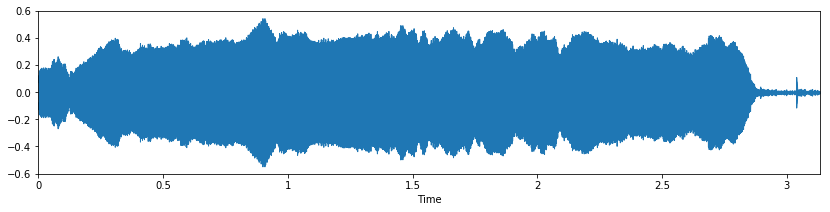

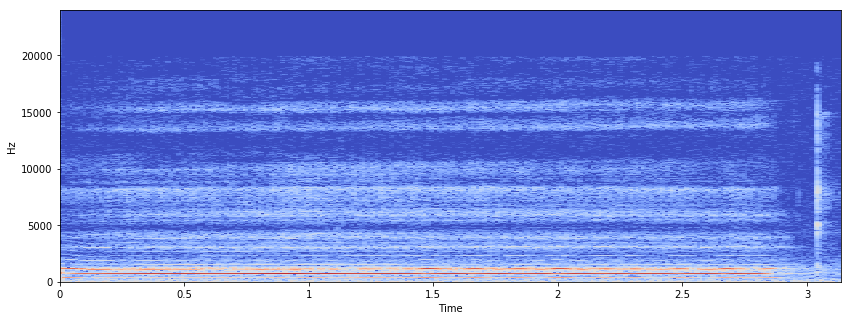

In [3]:
def showFile( fn ):
    fd = allFileData[fn]
    plt.figure( figsize=(14,3))
    librosa.display.waveplot(fd,sr=sr)
    X = librosa.stft(fd)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

showFile( 'ejkelly-g4-aah.wav')

In [4]:
fd = allFileData['ejkelly-g4-aah.wav']
pitches, magnitudes = librosa.core.piptrack(fd, sr=sr, fmin=75, fmax=2000, n_fft=2048)
[np.shape(pitches), np.shape(fd), np.shape(fd)[0] / np.shape(pitches)[1]]

[(1025, 294), (150416,), 511.6190476190476]

In [17]:
fd = allFileData['baconpaul-daughter-g-ahh.wav']
pitches, magnitudes = librosa.core.piptrack(fd, sr=sr, fmin=75, fmax=2000)
[np.shape(pitches), np.shape(fd), np.shape(fd)[0] / np.shape(pitches)[1]]

[(1025, 385), (196608,), 510.67012987012987]

OK great, so clearly the piptrack gives us the frequency spectrum in 512 block length intervals. That's really useful. At our sample rate how many blocks give us a tenth of a second? The answer is "about 10 blocks"

In [18]:
time = 512/sr
blocks = 0.1 / time
[time, blocks]

[0.010666666666666666, 9.375]

What's in that pitches array and magnitude array? Take a single slice

In [19]:
fd = allFileData['baconpaul-daughter-g-ahh.wav']
pitches, magnitudes = librosa.core.piptrack(fd, sr=sr, fmin=40, fmax=5000)

p120 = pitches[:,120]
m120 = magnitudes[:,120]

i0 = -1
for i in range(len(m120)):
    if( m120[i] > 5):
        if( i0 < 0 ):
            i0 = i
        print( p120[i], " " , m120[i], " ", p120[i] / p120[i0])

395.56644   26.871807   1.0
790.71655   28.013731   1.9989475
1183.9298   19.080135   2.9929986
1577.828   10.021453   3.9887812


And hey would you look at that, theres the fundamental and first four harmonics from that sample. Great.

And so now we can introduce

## A plan of attack

The dataset I want is all 10-block streaks where the fundamental is roughly the same, along with the fundamental. If I have that, I can use that streak to join together a tone at that fundamental. I can also do some alias-y time stretching and shrinking to adjust pitch. 

In [20]:
pitchAndMagnitudeData = {}
for k in allFileData.keys():
    pitchAndMagnitudeData[k] = librosa.core.piptrack(allFileData[k], sr=sr, fmin=40, fmax=5000)

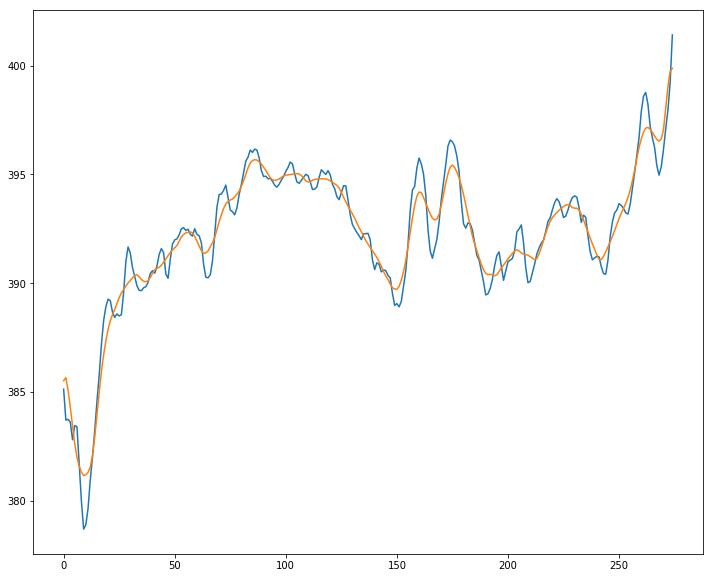

In [21]:
def fundaments(fn):
    (p,m) = pitchAndMagnitudeData[fn]
    shape = np.shape(p)
    nObs = shape[1]
    fundamental = np.zeros( nObs )
    for i in range( nObs ):
        thisp = p[:,i]
        thism = m[:,i]
        found = False
        for j in range( len( thisp ) ):
            if( thism[j] > 5 and not found ):
                fundamental[i] = thisp[j]
                found = True
            if( found ):
                break
    smoothed =  np.convolve( fundamental, np.ones((10,))/10, mode='same' )
    edges = np.abs(smoothed - fundamental)
    valid = np.logical_and( edges < 5, fundamental > 40 )
    return (fundamental, smoothed, valid )
    
(f,smoothed,valid) = fundaments( 'baconpaul-daughter-g-ahh.wav' )
plt.figure(figsize=(12, 10))
plt.plot( f[valid] )
plt.plot( smoothed[valid] )


So now we have a mechanism to find the approximate frequency of a 10 block chunk. Cool. So lets calculate that curve for everyone.

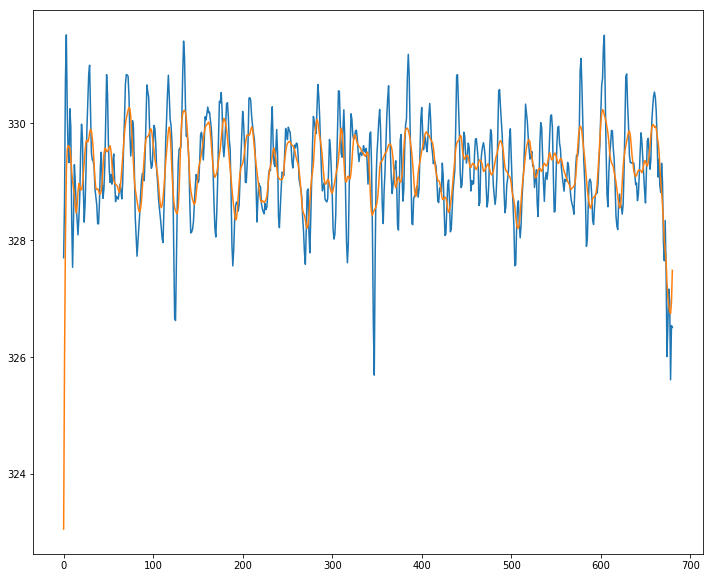

In [22]:
(f,smoothed,valid) = fundaments( 'samarobryn--e.wav' )
plt.figure(figsize=(12, 10))
plt.plot( f[valid] )
plt.plot( smoothed[valid] )


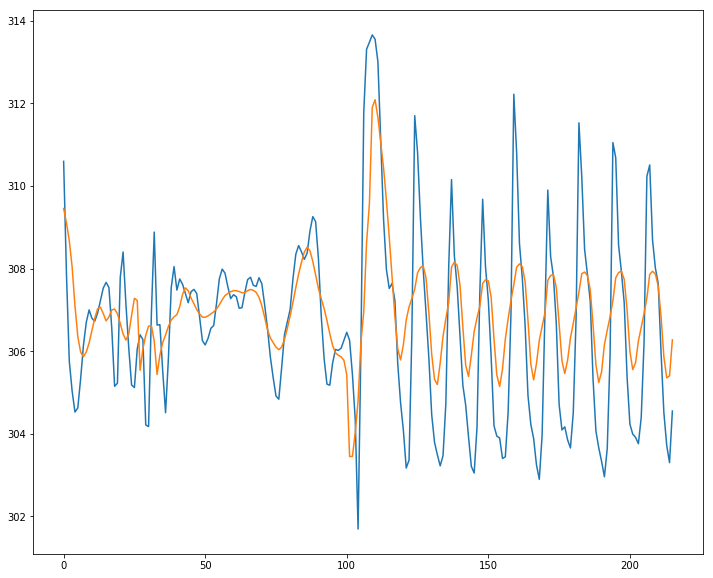

In [23]:
(f,smoothed,valid) = fundaments( 'Patricia Wolf Dischorus Ohhh.wav' )
plt.figure(figsize=(12, 10))
plt.plot( f[valid] )
plt.plot( smoothed[valid] )

In [24]:
fundamentsData = {}
for k in allFileData.keys():
    fundamentsData[k] = fundaments(k)

Alright so now I'm going to see if I can make a middle c (261.63) from this data set in any way. I'll do it by scanning all the fundamentsData lookign for things within +/- 2 of 261.63 and also valid and see how much I get. Then glue together those blocks. For now I'll do it silly and loopwise with no clever vector stuff.

In [99]:
def samplesNearFrequency(target):
    targetHigh = target * 1.03
    targetLow = target * 0.97

    files = []
    samples = {}
    flatsamples = []
    for k in fundamentsData.keys():
        (f,s,v) = fundamentsData[k]
        for i in range( len(f) ):
            if( v[i] and s[i] < targetHigh and s[i] > targetLow ):
                if( not k in samples ):
                    samples[k] = []
                    files.append(k)
            
                samples[k].append(i)
                flatsamples.append( (k,i))
    return( files, samples, flatsamples )

files,samples,fs = samplesNearFrequency(261.63)
files
        

['Zero Meaning Dischoir.wav',
 'samarobryn--o.wav',
 'Henk-Lasschuit--eu.wav',
 'ejkelly-c4-aah.wav',
 'eww Vonna Wolf.wav',
 'danieldiaz-e-syllabe-twice.wav',
 'samarobryn--u.wav',
 'ejkelly-c4-ooh.wav']

In [100]:
def freqForNote(n):
    return pow( 2.0, (n - 60 ) / 12.0 ) * 261.63

used = {}
for i in range( 49 ):
    p = freqForNote( i + 36 )
    f,s,u = samplesNearFrequency(p)
    print( 60-12-12+i, p, " ", len(f) )
    for e in f:
        used[e] = True
        

36 65.4075   3
37 69.29683234430561   10
38 73.41743642479531   12
39 77.78306437454047   8
40 82.40828607099891   4
41 87.30853776162652   5
42 92.50017358091822   8
43 98.00052013081155   17
44 103.82793430661002   18
45 110.00186456141466   24
46 116.54291581352848   21
47 123.47291821345574   20
48 130.815   18
49 138.59366468861123   19
50 146.83487284959062   23
51 155.56612874908095   15
52 164.81657214199782   18
53 174.61707552325305   9
54 185.00034716183643   12
55 196.0010402616231   11
56 207.65586861322004   14
57 220.00372912282933   25
58 233.08583162705696   19
59 246.94583642691148   4
60 261.63   8
61 277.18732937722245   7
62 293.66974569918125   5
63 311.1322574981619   6
64 329.63314428399565   7
65 349.2341510465061   3
66 370.00069432367286   3
67 392.0020805232462   7
68 415.31173722644   4
69 440.00745824565865   4
70 466.1716632541139   4
71 493.8916728538229   4
72 523.26   5
73 554.3746587544449   3
74 587.3394913983625   3
75 622.2645149963238   1
76 659.2

In [101]:
for k in allFileData.keys():
    if( not k in used ):
        print( k, "is unused" )

atomboyd--whisper-sigh.wav is unused


In [102]:
(f,s,fl) = samplesNearFrequency(130.815)
len(fl)

1174

OK so now lets do some DSP. We need to grab 15 items from random, and overlap them together with a window

In [103]:
block_size=512
nchunks = 10
chunkWindow = 5
random.seed(173204)
obs = []
for i in range(30):
    obs.append( fl[ random.randint(0,len(fl)) ] )
obs

[('zoundsabarΓÇöooo 2.wav', 543),
 ('Henk-Lasschuit--eu.wav', 61),
 ('zoundsabarΓÇöahh 1.wav', 522),
 ('zoundsabarΓÇöooo 2.wav', 29),
 ('zoundsabarΓÇöooo 2.wav', 383),
 ('Henk-Lasschuit--eu.wav', 247),
 ('zoundsabarΓÇömmm 2.wav', 547),
 ('Henk-Lasschuit--eu.wav', 96),
 ('Henk-Lasschuit--eu.wav', 343),
 ('zoundsabarΓÇöooo 2.wav', 426),
 ('zoundsabarΓÇöahh 1.wav', 612),
 ('baconpaul-c-mmm.wav', 66),
 ('baconpaul-c-mmm.wav', 358),
 ('zoundsabarΓÇöooo 2.wav', 202),
 ('baconpaul-c-mmm.wav', 190),
 ('zoundsabarΓÇöahh 1.wav', 524),
 ('Henk-Lasschuit--eu.wav', 89),
 ('baconpaul-c-mmm.wav', 33),
 ('zoundsabarΓÇöooo 2.wav', 31),
 ('zoundsabarΓÇöooo 2.wav', 572),
 ('baconpaul-c-mmm.wav', 107),
 ('baconpaul-c-mmm.wav', 295),
 ('MichelBanabila-voice.wav', 5),
 ('baconpaul-c-mmm.wav', 413),
 ('KRSeward-andsometimeswhyyy.wav', 725),
 ('baconpaul-c-mmm.wav', 230),
 ('zoundsabarΓÇöooo 2.wav', 261),
 ('zoundsabarΓÇöahh 1.wav', 616),
 ('baconpaul-c-mmm.wav', 193),
 ('zoundsabarΓÇöooo 2.wav', 575)]

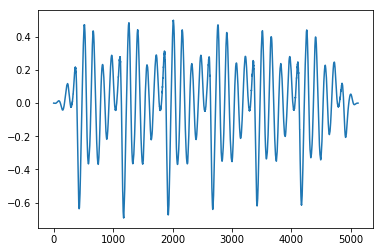

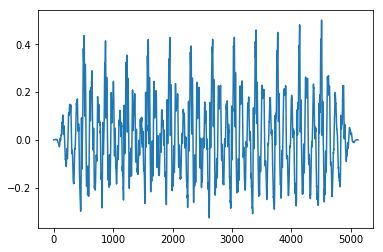

In [104]:
def segmentFromFileNonOver( fn, sp ):
    da = allFileData[fn]
    start = (sp-chunkWindow) * block_size
    if( start < 0 ):
        start = 0
    end = ( sp + chunkWindow ) * block_size
    if( end >= len(da)):
        end = len(da)
    seg = da[start:end]

    w = scipy.signal.windows.hann(block_size * 2)
    ws = w[0:block_size]
    we = w[block_size:]
    con = np.ones(len(seg)-len(w))
    r = np.concatenate( [ ws, con, we ] )
    mv = np.max( r * seg )
    
    return ( seg, r * seg / ( mv * 2 ), w)

(fn,sp) = obs[0]
(seg,faded,window) = segmentFromFileNonOver( fn, sp )
plt.plot(faded)
plt.show();
(fn,sp) = obs[1]
(seg,faded,window) = segmentFromFileNonOver( fn, sp )
plt.plot(faded)
plt.show();



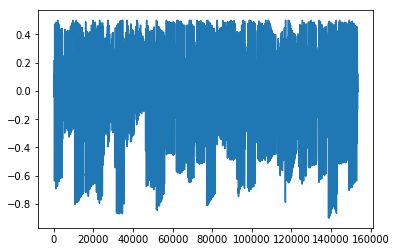

In [105]:
def concatObservations(obs):
    ss = []
    for (f,s) in obs:
        (seg,faded,window) = segmentFromFileNonOver(f,s)
        ss.append(faded)
    res = np.concatenate(ss)
    return res

res = concatObservations(obs)
plt.plot(res)

In [93]:
ipd.Audio(res, rate=sr)

In [107]:
# Great. Can we make a C major chord?

inter = []
notes = [ 48, 52, 55 ];
random.seed(173206)

for n in notes:
    freq = freqForNote(n)
    (f,s,fl) = samplesNearFrequency(freq)
    obsC = []
    for i in range(30):
        obsC.append( fl[ random.randint(0,len(fl)-1) ] )
    res = concatObservations(obsC)
    inter.append(res)
    
finalR = inter[0] * 0.2
for i in range(1,len(inter)):
    finalR = finalR + inter[i] * 0.2

ipd.Audio( finalR, rate=sr )